In [1]:
#Import dependency
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import requests
import psycopg2
import config as creds


In [2]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [3]:
# Connecting to DB

conn, cursor = connect()

# SQL command to create inventory table
sql = "select * from ames;"
#cursor.execute(sql)
df = pd.read_sql_query(sql, conn)
#conn.commit()
# dat = pd.read_sql_query(sql, conn)


**Final Data Cleaning before importing the dataset into our model**

In [4]:
#Drop the ames_order, pid column since it doesn't help with prediction
df.drop(columns=["ames_order","pid"], axis=1, inplace=True)
df

,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,neighborhood,condition1,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,0,0,0,0,5,2010,WD,Normal,215000,4920
1,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,0,120,0,0,6,2010,WD,Normal,105000,3404
2,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
3,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,NAmes,Norm,...,0,0,0,0,4,2010,WD,Normal,244000,6852
4,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,0,0,0,0,3,2010,WD,Normal,189900,4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,Mitchel,Norm,...,0,0,0,0,3,2006,WD,Normal,142500,3597
2758,20,RL,8885,Pave,IR1,Low,Inside,Mod,Mitchel,Norm,...,0,0,0,0,6,2006,WD,Normal,131000,3152
2759,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,...,0,0,0,700,7,2006,WD,Normal,132000,2852
2760,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,Mitchel,Norm,...,0,0,0,0,4,2006,WD,Normal,170000,4585


In [5]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype',
       'salecondition'],
      dtype='object')

In [6]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice', 'total_area'],
      dtype='object')

**check histogram and see if they are normally distributed in order to be used in linear regression model --> transform the skewed numeric features by taking log(feature + 1) -->make features more normally distributed**

In [7]:
#Check skewness of the dataset
from scipy.stats import skew 
skewness = numerical.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

miscval          21.358067
poolarea         16.432732
lotarea          12.990651
lowqualfinsf     12.131730
3ssnporch        11.343489
kitchenabvgr      4.220799
bsmtfinsf2        4.026744
enclosedporch     3.979661
screenporch       3.882597
bsmthalfbath      3.818322
openporchsf       2.660786
masvnrarea        2.474363
saleprice         1.837788
wooddecksf        1.824971
1stflrsf          1.513314
bsmtfinsf1        1.431787
total_area        1.357359
grlivarea         1.289576
totalbsmtsf       1.193826
bsmtunfsf         0.938686
2ndflrsf          0.914635
totrmsabvgrd      0.765231
halfbath          0.761664
fireplaces        0.725214
bsmtfullbath      0.616436
bedroomabvgr      0.303137
garagearea        0.266859
fullbath          0.238783
mosold            0.188568
yrsold            0.141621
garagecars       -0.175933
yearremodadd     -0.392857
yearbuilt        -0.559509
garageyrblt      -3.929012
dtype: float64

In [8]:
#normalize the data by taking log
skewness = np.log(skewness)
skewness.sort_values(ascending=False)

C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


miscval          3.061430
poolarea         2.799275
lotarea          2.564230
lowqualfinsf     2.495824
3ssnporch        2.428644
kitchenabvgr     1.440024
bsmtfinsf2       1.392958
enclosedporch    1.381197
screenporch      1.356504
bsmthalfbath     1.339811
openporchsf      0.978621
masvnrarea       0.905983
saleprice        0.608563
wooddecksf       0.601564
1stflrsf         0.414302
bsmtfinsf1       0.358923
total_area       0.305541
grlivarea        0.254313
totalbsmtsf      0.177163
bsmtunfsf       -0.063274
2ndflrsf        -0.089231
totrmsabvgrd    -0.267578
halfbath        -0.272250
fireplaces      -0.321288
bsmtfullbath    -0.483801
bedroomabvgr    -1.193569
garagearea      -1.321035
fullbath        -1.432200
mosold          -1.668299
yrsold          -1.954603
yearbuilt             NaN
yearremodadd          NaN
garageyrblt           NaN
garagecars            NaN
dtype: float64

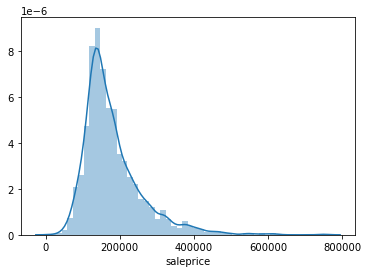

In [9]:
# check if saleprice is normally distributed in order to be used in our Multiple linear regression model later
sns.distplot(df['saleprice']);
#we can see the saleprice is right skewed

# transform the the saleprice by taking log to make the data more normally distribute
df['saleprice'] = np.log1p(df['saleprice'])

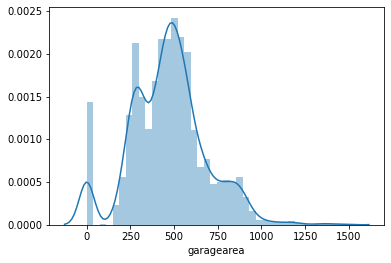

In [10]:
#check the distribution of garagearea
sns.distplot(df['garagearea']);

In [11]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

mssubclass       0
mszoning         0
lotarea          0
street           0
lotshape         0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 65, dtype: int64

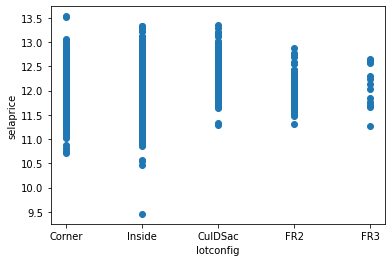

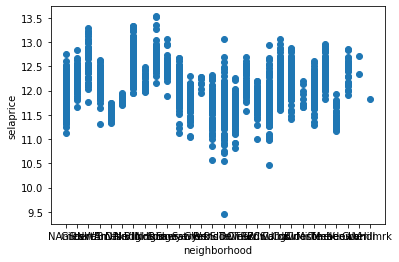

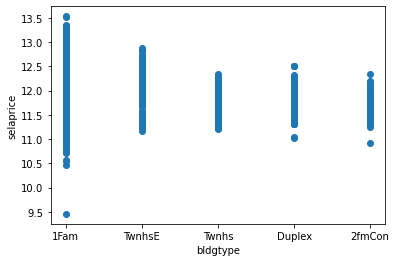

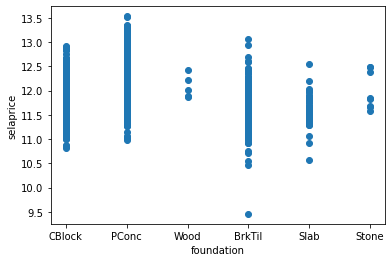

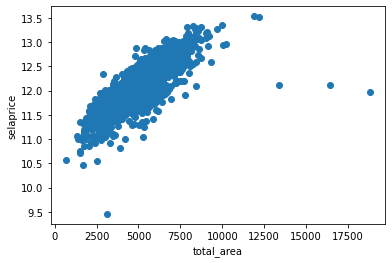

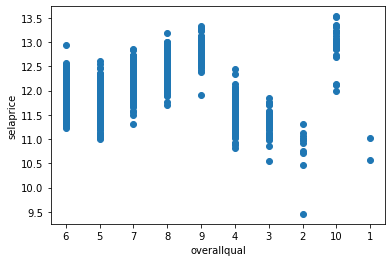

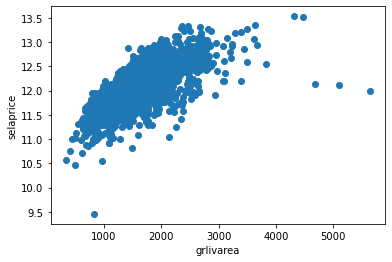

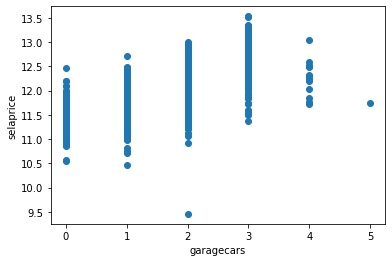

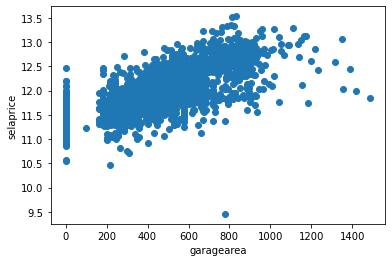

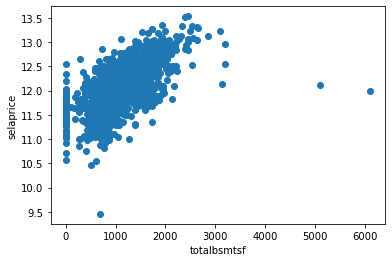

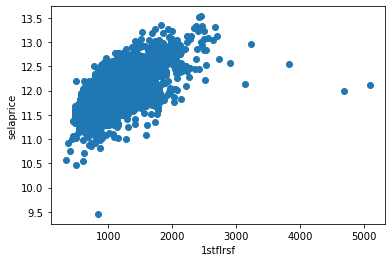

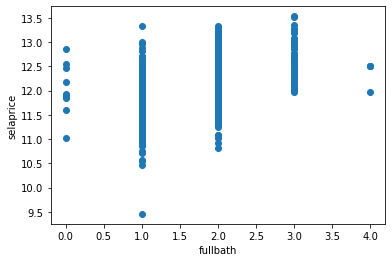

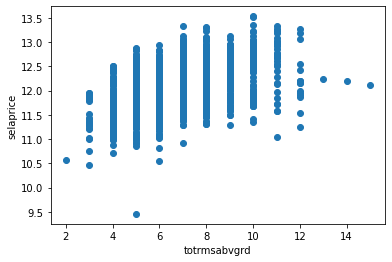

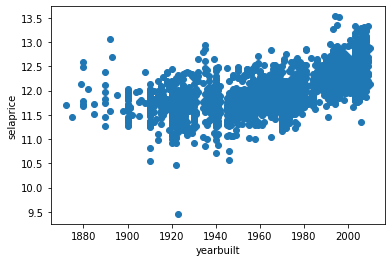

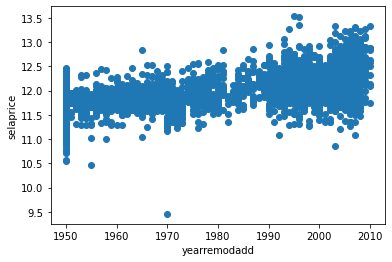

In [12]:
#See the relationship between selected features and target
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

# **Initial Features Selection**
we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5). We also added another additional features: total_area

* overallqual
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd
* ADDED total_area

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* lotconfig
* neighborhood
* bldgtype
* foundation


In [13]:
#Determine features and target
feature = df.drop(columns=['saleprice'])
target = df['saleprice']

print(feature)
print(target)

     mssubclass mszoning  lotarea street lotshape landcontour lotconfig  \
0            20       RL    31770   Pave      IR1         Lvl    Corner   
1            20       RH    11622   Pave      Reg         Lvl    Inside   
2            20       RL    14267   Pave      IR1         Lvl    Corner   
3            20       RL    11160   Pave      Reg         Lvl    Corner   
4            60       RL    13830   Pave      IR1         Lvl    Inside   
...         ...      ...      ...    ...      ...         ...       ...   
2757         80       RL     7937   Pave      IR1         Lvl   CulDSac   
2758         20       RL     8885   Pave      IR1         Low    Inside   
2759         85       RL    10441   Pave      Reg         Lvl    Inside   
2760         20       RL    10010   Pave      Reg         Lvl    Inside   
2761         60       RL     9627   Pave      Reg         Lvl    Inside   

     landslope neighborhood condition1  ... enclosedporch 3ssnporch  \
0          Gtl        NAmes 

**Use Label Encoder to to transform categorical features**

In [14]:
#Convert numerical categories that shouldn't be numerical to categorical categories
#please refer to the description file for definition of each category
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond'] = df['overallcond'].astype(str)
df['overallqual'] = df['overallqual'].astype(str)
df.dtypes

mssubclass        object
mszoning          object
lotarea            int64
street            object
lotshape          object
                  ...   
yrsold            object
saletype          object
salecondition     object
saleprice        float64
total_area         int64
Length: 65, dtype: object

In [15]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ('mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'mosold',
       'yrsold', 'saletype', 'salecondition')

for col in cols:
  le = LabelEncoder()
  le.fit(list(df[col].values))
  df[col] = le.fit_transform(list(df[col].values))
df.shape  

(2762, 65)

# **Step 4: Multiple Linear Regression Model: Predict house prices based on the selected features**
* Set x and y
* Scale x and y
* Split the data into train and test (X:features, y=target)
* Create an instance of the model with model = LinearRegression().
* Train the model with the dataset with model.fit(X,y)
* Create predictions with y_pred = model.predict(X)


In [81]:
#put our selected features into a list

cols = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]
#cols = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","totrmsabvgrd", "yearbuilt","yearremodadd"]
#try using only the numerical category
#cols = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

#take away the "grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath" that were used to calculate "total area"

#assign y to our target and x to our features 
y = df['saleprice'].values
X = df[cols]

#try using all the columns as features
# X = df.loc[:, df.columns != 'saleprice']

#scale the data
X_scaled = preprocessing.StandardScaler().fit_transform(X)
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))


Perform 80/20 data split

In [82]:
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2209, 8), (553, 8), (2209, 1), (553, 1))

**Fit data to our Multiple Linear Regression Model**

In [83]:
#define the model
model = linear_model.LinearRegression()
#build training model --> time start time 
start=datetime.now()
model.fit(X_train, y_train)

#time the end time
end=datetime.now()

#run prediction on test set 
y_test_pred = model.predict(X_test)


In [84]:
#print the coefficient, intercept, MSE and model score(R^2),and model run time
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared Error(MSE): {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Coefficient of Determination(R^2): {r2_score(y_test, y_test_pred):.2f}")
time_taken = end - start
print(f"Time to run the model: {time_taken}")


Coefficients: [[ 0.01074055  0.53138164  0.24171858  0.08892084 -0.04636545  0.1709812
   0.13384152 -0.01929773]]
Intercept: [-0.00469964]
Mean squared Error(MSE): 0.16
Coefficient of Determination(R^2): 0.86
Time to run the model: 0:00:00.001227


In [85]:
#Formula for our multiple linear regression model

#y = -0.00469964 + 0.01074055*neighborhood + 0.53138164*total_area + 0.24171858*overallqual + 0.08892084*garagecars + (-0.04636545*fullbath) + 0.1709812*yearbuilt +0.13384152*yearremodadd +(-0.01929773*yrsold) 

In [86]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
nn_model.summary()
nn_model.compile(loss="mean_squared_error", optimizer="adam")
#time starting time
start_1=datetime.now()
nn_model.fit(X_train_scaled, np.asarray(y_train), epochs=100)
#time ending time
end_1=datetime.now()

y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)

deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu"))
deep_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
deep_model.summary()

deep_model.compile(loss="mean_squared_error", optimizer="adam")
#start deep learning starting time
start_2=datetime.now()
deep_model.fit(X_train_scaled, np.asarray(y_train), epochs=100)
#time deep learning ending time
end_2=datetime.now()
y_train_pred = deep_model.predict(X_train_scaled)
y_test_pred = deep_model.predict(X_test_scaled)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2209/2209 [==============================] - 0s 219us/sample - loss: 0.9147
Epoch 2/100
2209/2209 [==============================] - 0s 29us/sample - loss: 0.7797
Epoch 3/100
2209/2209 [==============================] - 0s 29us/sample - loss: 0.6925
Epoch 4/100
2209/2209 [==============================] - 0s 29us/sample - loss: 0.6273
Epoch 5/100
2209/2209 [==============================] - 0s 31us/sample - loss: 0.5687
Epoch 6/100
2209/2209 [==============================] - 0s 29us/sample - loss: 0

2209/2209 [==============================] - 0s 24us/sample - loss: 0.1834
Epoch 88/100
2209/2209 [==============================] - 0s 25us/sample - loss: 0.1819
Epoch 89/100
2209/2209 [==============================] - 0s 24us/sample - loss: 0.1832
Epoch 90/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1811
Epoch 91/100
2209/2209 [==============================] - 0s 24us/sample - loss: 0.1822
Epoch 92/100
2209/2209 [==============================] - 0s 27us/sample - loss: 0.1807
Epoch 93/100
2209/2209 [==============================] - 0s 27us/sample - loss: 0.1814
Epoch 94/100
2209/2209 [==============================] - 0s 34us/sample - loss: 0.1809
Epoch 95/100
2209/2209 [==============================] - 0s 33us/sample - loss: 0.1819
Epoch 96/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1844
Epoch 97/100
2209/2209 [==============================] - 0s 25us/sample - loss: 0.1800
Epoch 98/100
2209/2209 [=====================

2209/2209 [==============================] - 0s 26us/sample - loss: 0.1513
Epoch 72/100
2209/2209 [==============================] - 0s 25us/sample - loss: 0.1524
Epoch 73/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1502
Epoch 74/100
2209/2209 [==============================] - 0s 22us/sample - loss: 0.1530
Epoch 75/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1508
Epoch 76/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1536
Epoch 77/100
2209/2209 [==============================] - 0s 29us/sample - loss: 0.1531
Epoch 78/100
2209/2209 [==============================] - 0s 28us/sample - loss: 0.1549
Epoch 79/100
2209/2209 [==============================] - 0s 24us/sample - loss: 0.1495
Epoch 80/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1494
Epoch 81/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.1507
Epoch 82/100
2209/2209 [=====================

In [87]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))
time_taken_neu = end_1 - start_1
print(time_taken_neu)

time_taken_dl = end_2 - start_2
print(time_taken_dl)

0.8476222144002582
0.8863275297474358
0:00:06.254351
0:00:06.131516


C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


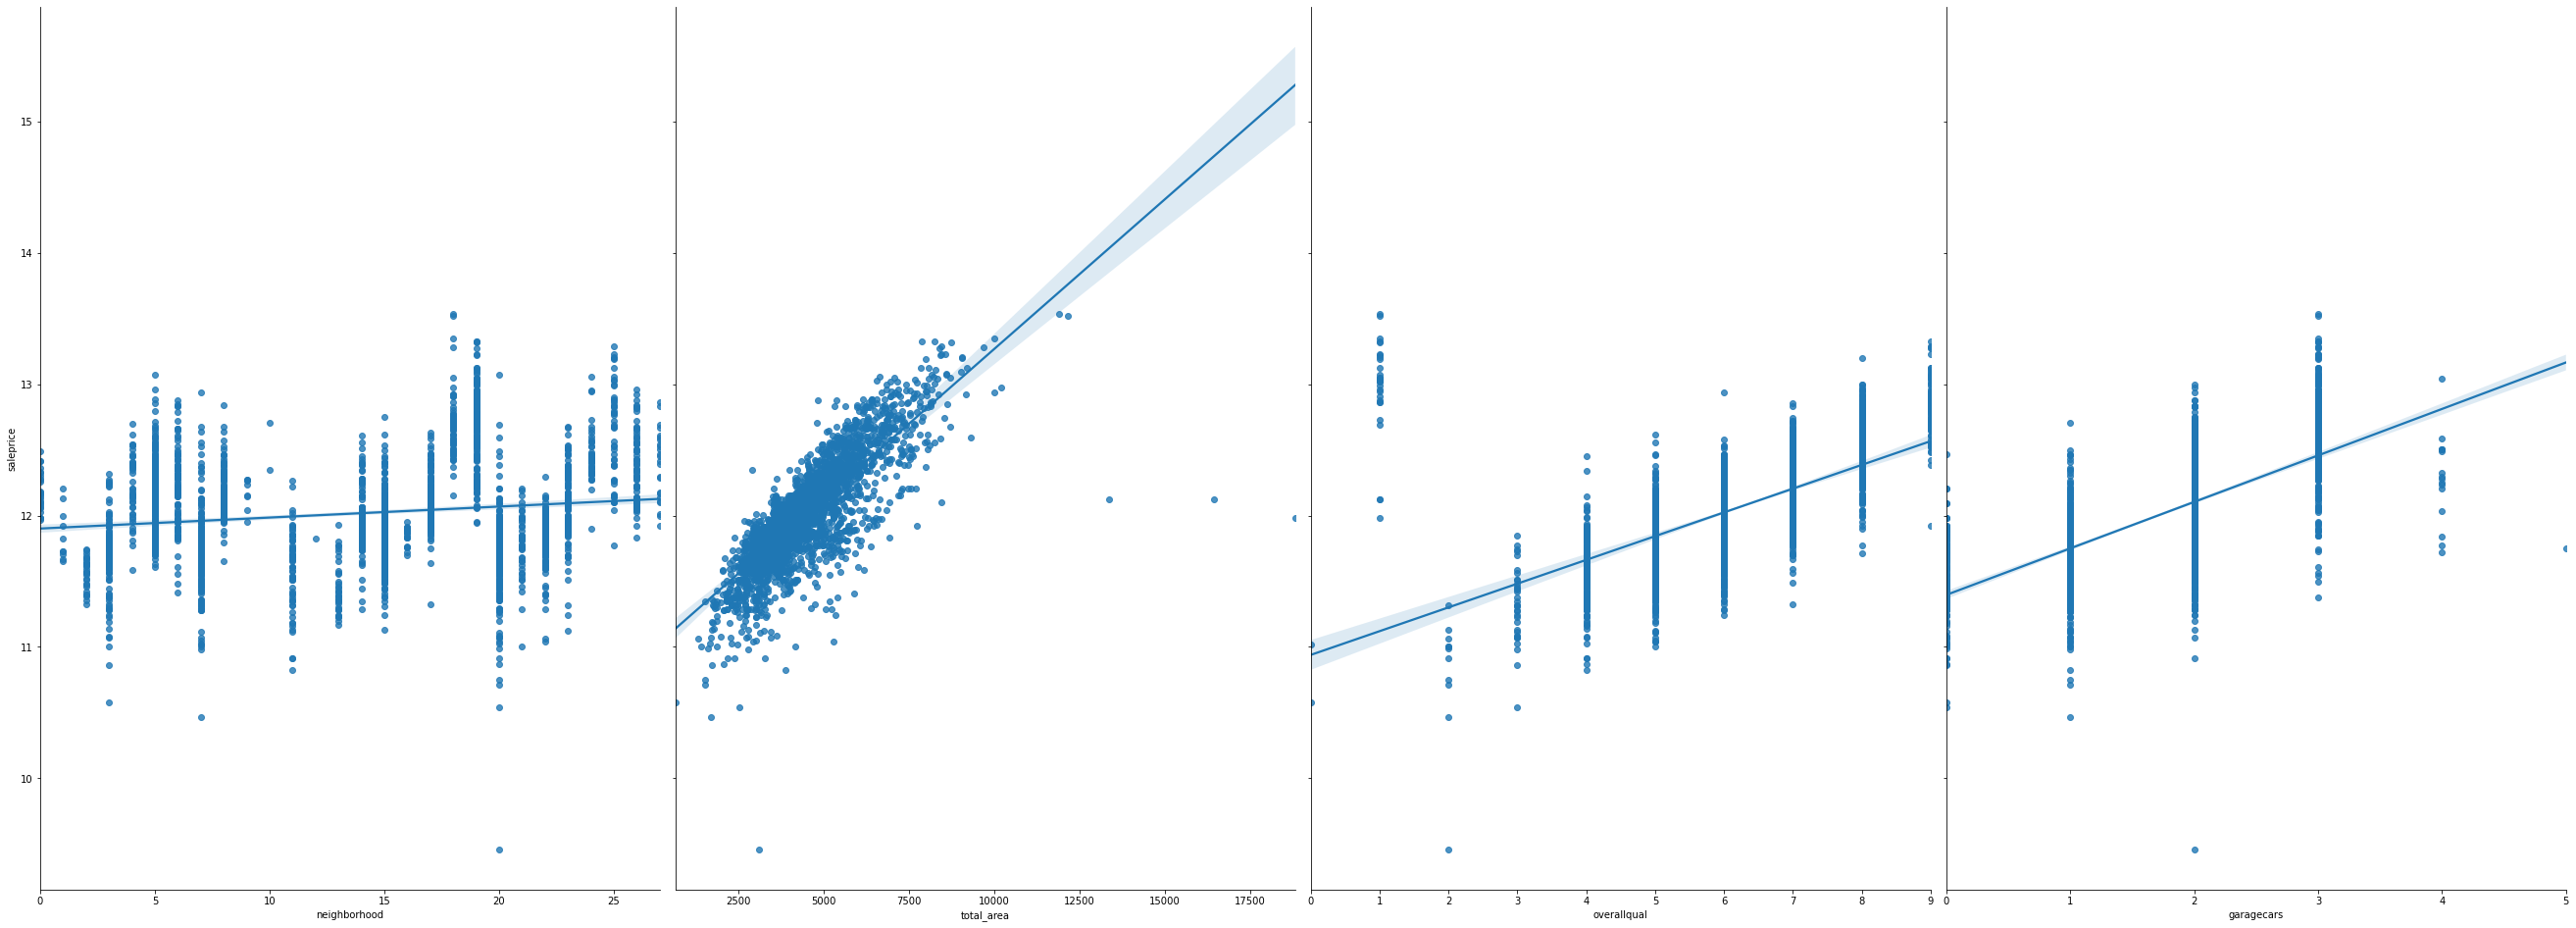

In [88]:
sns.pairplot(df, x_vars=["neighborhood","total_area","overallqual", "garagecars"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')

C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


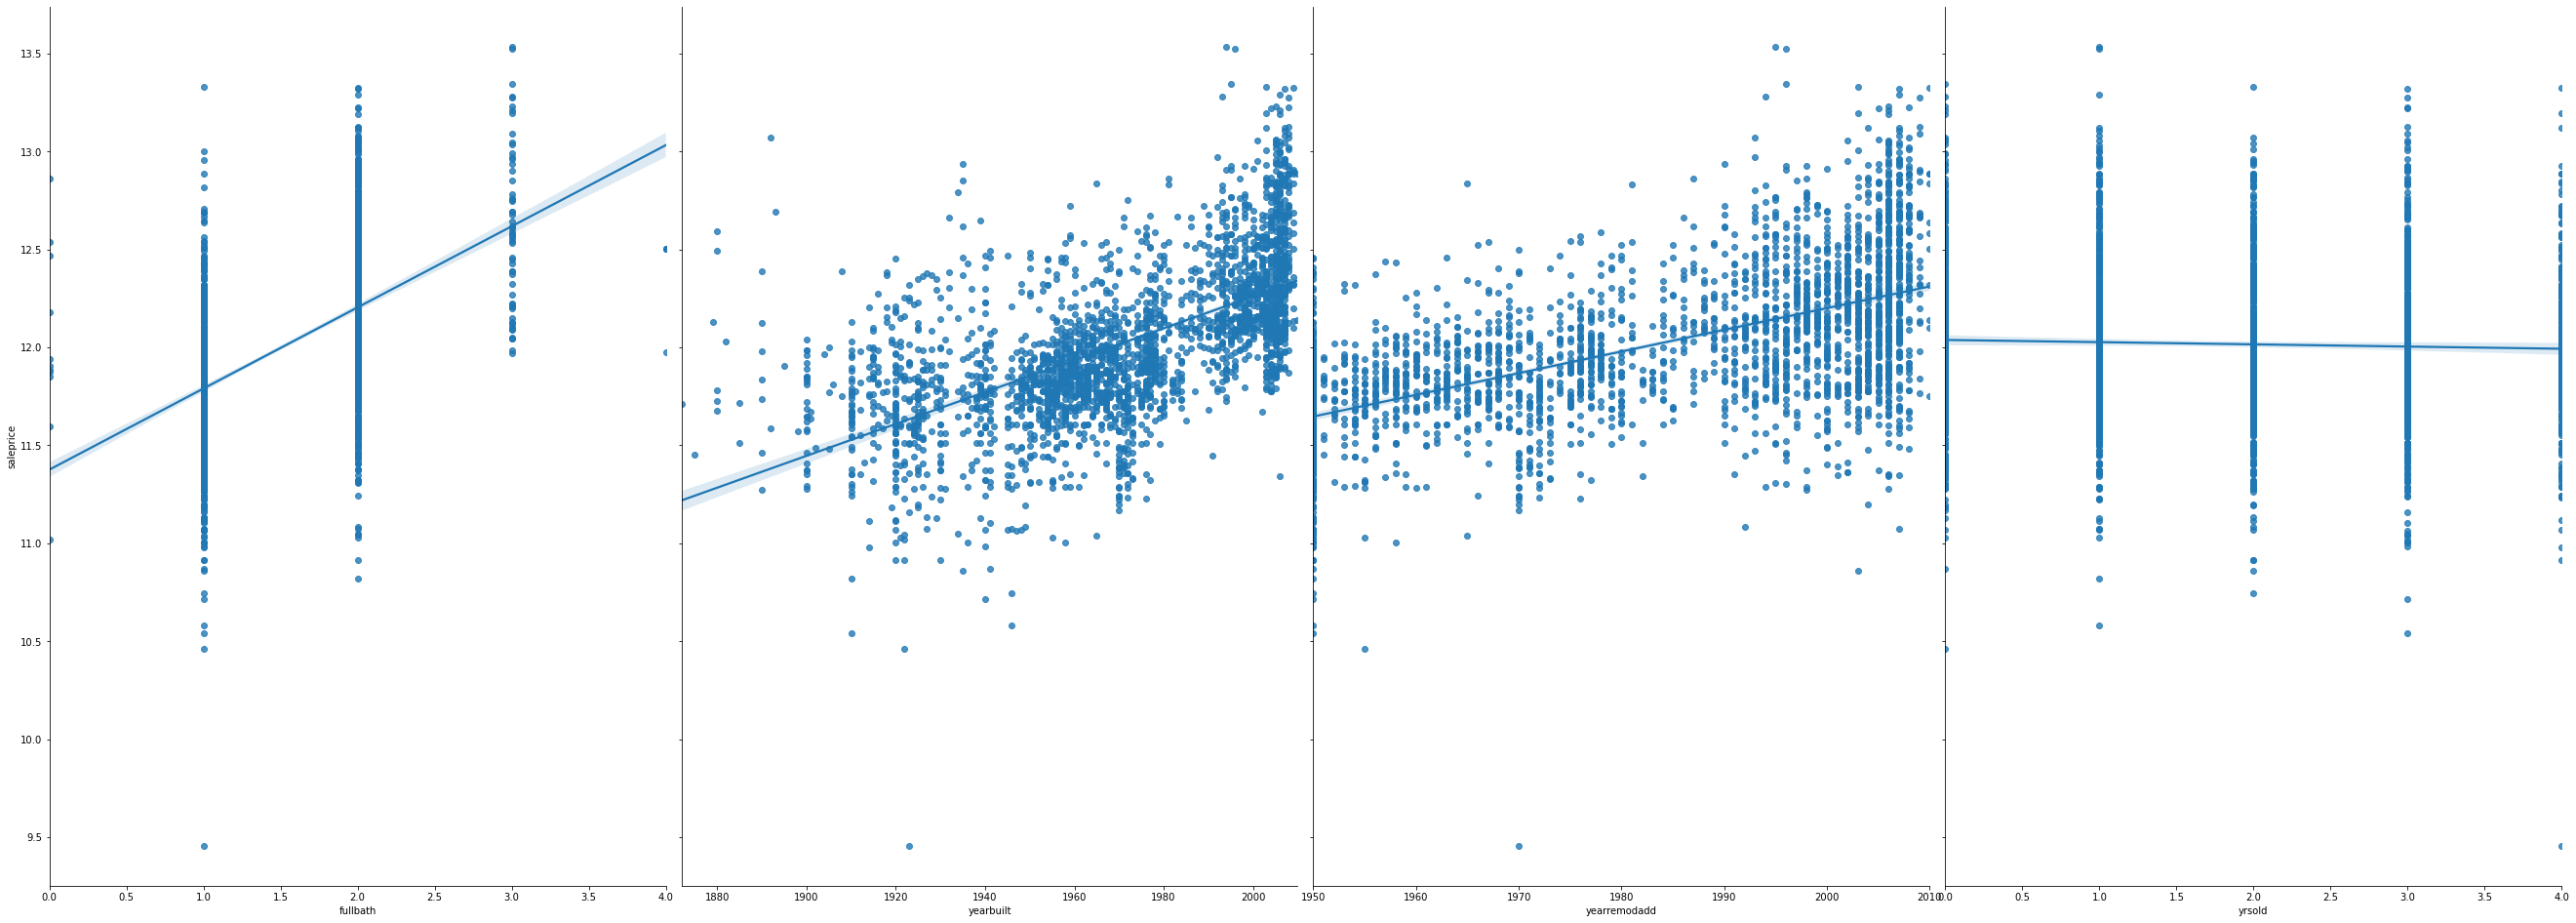

In [89]:
sns.pairplot(df, x_vars=["fullbath","yearbuilt","yearremodadd","yrsold"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')


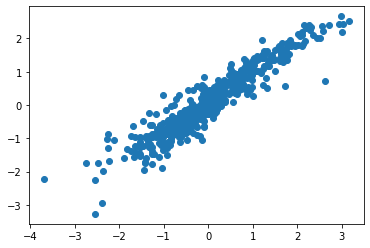

In [90]:
#graph the relationship between y_test and t_test_pred
plt.scatter(y_test, y_test_pred)
plt.show()


# Models Comparison


**Comparing Multiple Linear Regression VS Deep Learning in terms of model running time**

In [91]:
#import the recording of the model run time and model result
data = pd.read_csv('Resources/run_time_r2.csv')
data = data.dropna()
data

,Features,MLR_R^2,MLR^Run_Time,DL_R^2,DL_Run_Time
0,64,0.90,0.006,0.91,12.12
1,54,0.90,0.003,0.89,12.38
2,44,0.89,0.003,0.87,12.18
3,34,0.88,0.003,0.81,12.53
4,24,0.86,0.003,0.85,12.31
5,15,0.85,0.002,0.82,12.44
6,11,0.85,0.002,0.88,12.71
7,9,0.85,0.002,0.89,12.80
8,8,0.86,0.002,0.89,12.38


<BarContainer object of 2 artists>

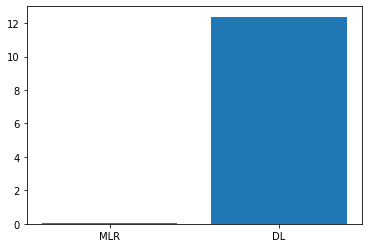

In [93]:
Features = ["8", "15"]
x = ['MLR', 'DL']
y = [0.02, 12.38]
plt.bar(x,y)

**Comparing Multiple Linear Regression VS Deep Learning in terms of R^2**

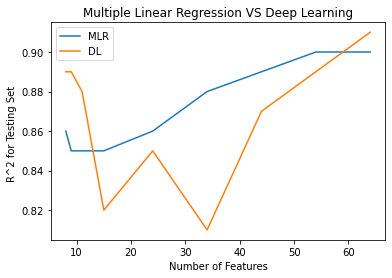

In [94]:
x = data.Features
MLR = data['MLR_R^2']
DL = data['DL_R^2']
fig, ax = plt.subplots()
ax.plot(x,MLR, label='MLR')
ax.plot(x,DL, label='DL')
ax.set_title("Multiple Linear Regression VS Deep Learning")
ax.set_xlabel("Number of Features")
ax.set_ylabel("R^2 for Testing Set ")
ax.legend()